In [4]:
! pip install openpyxl

In [5]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

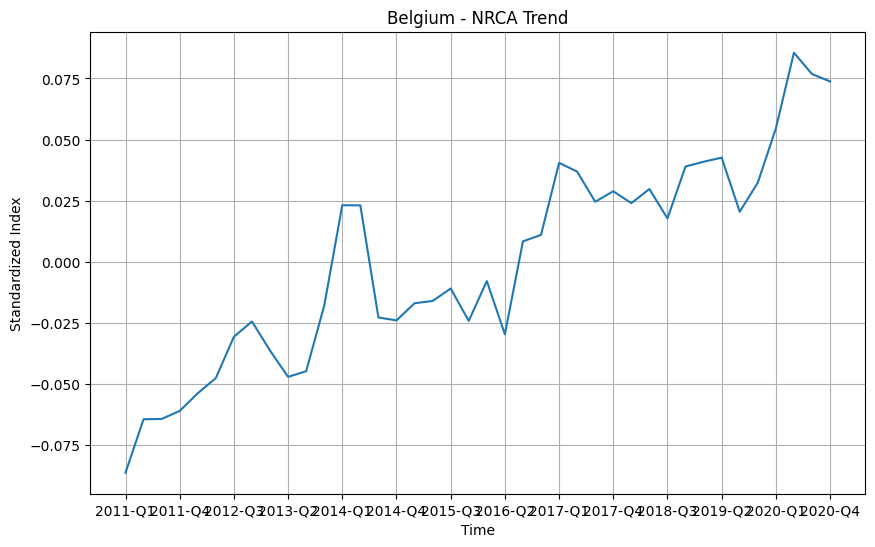

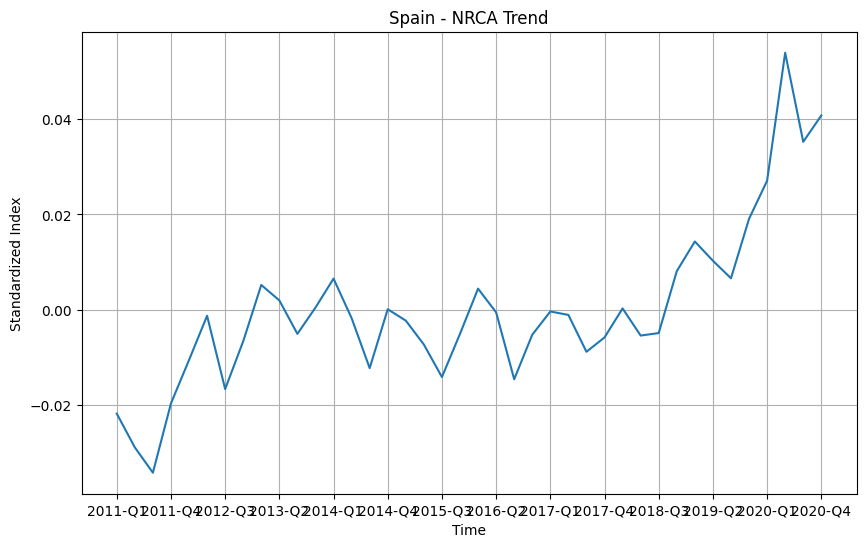

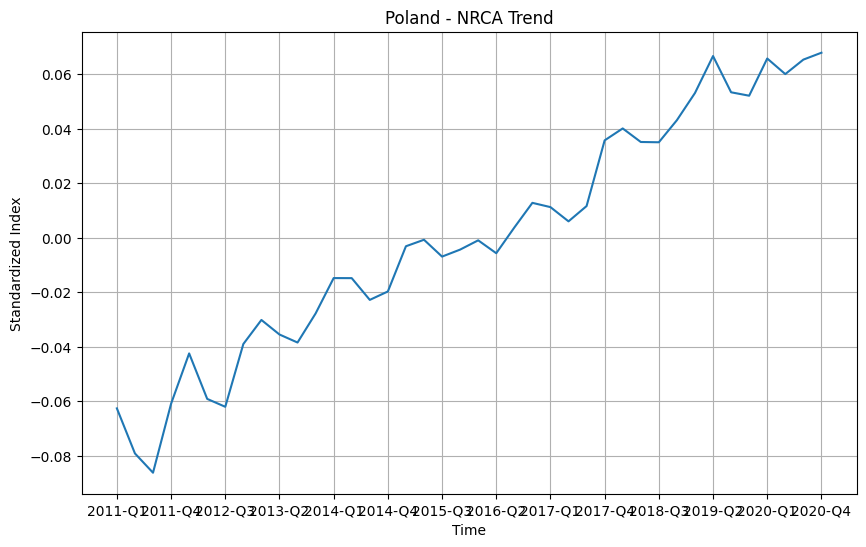

In [6]:
def setup_environment():
    os.chdir("C:\\Me\\IQF-2nd semester\\Reproducible research\\repositories\\RRcourse2025")
    return "Data"

def load_task_data(data_dir):
    task_data = pd.read_csv(f"{data_dir}\\onet_tasks.csv")
    task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)
    return task_data.groupby(["isco08_1dig"]).mean().drop(columns=["isco08"])

def load_employment_data(data_dir, countries):
    isco_dfs = []
    for i in range(1, 10):
        df = pd.read_excel(f"{data_dir}\\Eurostat_employment_isco.xlsx", sheet_name=f"ISCO{i}")
        df['ISCO'] = i
        isco_dfs.append(df)
    
    all_data = pd.concat(isco_dfs, ignore_index=True)
    
    for country in countries:
        total = sum(df[country] for df in isco_dfs)
        all_data[f"total_{country}"] = pd.concat([total]*9, ignore_index=True)
        all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]
    
    return all_data

def standardize_variables(data, countries, variables):
    for country in countries:
        for var in variables:
            weighted_mean = np.average(data[var], weights=data[f"share_{country}"])
            weighted_std = np.sqrt(np.average((data[var] - weighted_mean)**2, 
                                            weights=data[f"share_{country}"]))
            data[f"std_{country}_{var}"] = (data[var] - weighted_mean) / weighted_std
    return data

def calculate_nrca_index(data, countries):
    nrca_vars = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]
    
    for country in countries:
        data[f"{country}_NRCA"] = sum(data[f"std_{country}_{var}"] for var in nrca_vars)
        
        weighted_mean = np.average(data[f"{country}_NRCA"], weights=data[f"share_{country}"])
        weighted_std = np.sqrt(np.average((data[f"{country}_NRCA"] - weighted_mean)**2, 
                                        weights=data[f"share_{country}"]))
        data[f"std_{country}_NRCA"] = (data[f"{country}_NRCA"] - weighted_mean) / weighted_std
        
        data[f"multip_{country}_NRCA"] = data[f"std_{country}_NRCA"] * data[f"share_{country}"]
    
    return data

def plot_country_trends(data, countries, variable_suffix):
    for country in countries:
        agg_data = data.groupby(["TIME"])[f"multip_{country}_{variable_suffix}"].sum().reset_index()
        
        plt.figure(figsize=(10, 6))
        plt.plot(agg_data["TIME"], agg_data[f"multip_{country}_{variable_suffix}"])
        plt.xticks(range(0, len(agg_data), 3), agg_data["TIME"][::3])
        plt.title(f"{country} - {variable_suffix} Trend")
        plt.xlabel("Time")
        plt.ylabel("Standardized Index")
        plt.grid(True)
        plt.show()

def main():
    data_dir = setup_environment()
    countries = ["Belgium", "Spain", "Poland"]

    task_data = load_task_data(data_dir)
    employment_data = load_employment_data(data_dir, countries)

    combined = pd.merge(employment_data, task_data, left_on='ISCO', right_index=True, how='left')

    task_vars = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]
    combined = standardize_variables(combined, countries, task_vars)

    combined = calculate_nrca_index(combined, countries)

    plot_country_trends(combined, countries, "NRCA")

if __name__ == "__main__":
    main()